# 🧠 Proyecto NLP - Clasificación de Comentarios Tóxicos
Este proyecto aplica procesamiento de lenguaje natural (NLP) para clasificar comentarios en distintas categorías de toxicidad. Se basa en el dataset de Kaggle *Toxic Comment Classification Challenge*.

## 1. Carga de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar dataset
df = pd.read_csv('train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## 2. Exploración y distribución de etiquetas

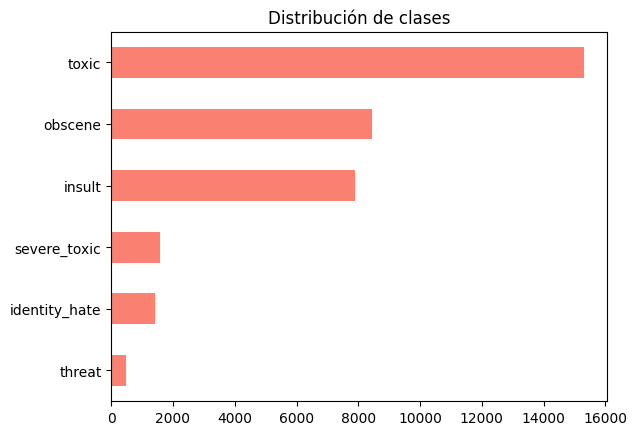

In [2]:
# Columnas objetivo
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df[labels].sum().sort_values().plot(kind='barh', color='salmon')
plt.title('Distribución de clases')
plt.show()

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mendo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 3. Preprocesamiento de texto

In [4]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    return ' '.join(tokens)

df['comment_text_clean'] = df['comment_text'].apply(clean_text)
df[['comment_text', 'comment_text_clean']].head()

,comment_text,comment_text_clean
0,Explanation\nWhy the edits made under my usern...,explan edit made usernam hardcor metallica fan...
1,D'aww! He matches this background colour I'm s...,daww match background colour im seem stuck tha...
2,"Hey man, I'm really not trying to edit war. It...",hey man im realli tri edit war guy constant re...
3,"""\nMore\nI can't make any real suggestions on ...",cant make real suggest improv wonder section s...
4,"You, sir, are my hero. Any chance you remember...",sir hero chanc rememb page that


## 4. Vectorización TF-IDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = vectorizer.fit_transform(df['comment_text_clean'])
y = df[labels].values

## 5. Modelos base: Logistic Regression y Naive Bayes

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
#from xgboost import XGBClassifier


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Probar ambos modelos
# Modelos a comparar
models_to_test = {
"LogisticRegression": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "LinearSVC": OneVsRestClassifier(LinearSVC(max_iter=1000)),
    #"XGBoost": OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0))
    # ⚠️ Nota: Se comenta XGBoost por incompatibilidad con scikit-learn en esta versión.
# Si se desea usar, actualizar XGBoost a >= 1.6.1 con: pip install --upgrade xgboost

}

# Entrenar y evaluar
model_f1_results = {}
for name, model in models_to_test.items():
    print(f"Entrenando modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1s = [f1_score(y_test[:, i], y_pred[:, i], zero_division=0) for i in range(6)]
    model_f1_results[name] = {
        "F1 por clase": [round(f, 3) for f in f1s],
        "F1 promedio": round(np.mean(f1s), 3)
    }

Entrenando modelo: LogisticRegression
Entrenando modelo: RandomForest
Entrenando modelo: LinearSVC


## 6. Red Neuronal Simple (Keras)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(256, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.5),
    Dense(6, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

c:\Users\Mendo\anaconda3\envs\nlp_tensorflow\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,561,798 (9.77 MB)

 Trainable params: 2,561,798 (9.77 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Entrenamiento
X_train_nn = X_train.toarray()
X_test_nn = X_test.toarray()
model.fit(X_train_nn, y_train, epochs=3, batch_size=512, validation_data=(X_test_nn, y_test))

Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.4972 - loss: 0.3087 - val_accuracy: 0.9941 - val_loss: 0.0725
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9816 - loss: 0.0657 - val_accuracy: 0.9941 - val_loss: 0.0595
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9565 - loss: 0.0551 - val_accuracy: 0.9941 - val_loss: 0.0563


## 7. Evaluación de la Red Neuronal

In [14]:
y_pred_nn = model.predict(X_test_nn)
y_pred_bin = (y_pred_nn > 0.5).astype(int)

f1_scores = [f1_score(y_test[:, i], y_pred_bin[:, i]) for i in range(6)]
print("F1 por clase:", np.round(f1_scores, 3))
print("F1 promedio:", np.round(np.mean(f1_scores), 3))

998/998 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
F1 por clase: [0.745 0.199 0.754 0.    0.656 0.12 ]
F1 promedio: 0.412


## 8. Conclusiones y próximos pasos

- Los modelos base ofrecen una línea base útil para clasificación de texto multiclase.
- La red neuronal simple mejora resultados al capturar patrones no lineales.
- Se pueden explorar modelos preentrenados (como BERT) para mayor precisión.

## 🔍 Comparación de Modelos Clásicos Multilabel

In [23]:
# ⚠️ Se carga solo una muestra del dataset por rendimiento
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
#from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

# Leer muestra
df = pd.read_csv("train.csv", nrows=5000)
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['comment_text_clean'] = df['comment_text'].fillna('').str.lower()
vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['comment_text_clean'])
y = df[label_columns].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models_to_test = {
"LogisticRegression": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "LinearSVC": OneVsRestClassifier(LinearSVC(max_iter=1000)),
    #"XGBoost": OneVsRestClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0))
}

model_f1_results = {}
for name, model in models_to_test.items():
    print(f"Entrenando modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1s = [f1_score(y_test[:, i], y_pred[:, i], zero_division=0) for i in range(6)]
    model_f1_results[name] = {
        "F1 por clase": [round(f, 3) for f in f1s],
        "F1 promedio": round(np.mean(f1s), 3)
    }

# Crear DataFrame base desde los resultados
results_df = pd.DataFrame(model_f1_results).T

# Expandir columna "F1 por clase" en columnas separadas
f1_split = pd.DataFrame(results_df['F1 por clase'].tolist(),
                        columns=['F1_toxic', 'F1_severe_toxic', 'F1_obscene',
                                 'F1_threat', 'F1_insult', 'F1_identity_hate'])
# Alinear índices para que el concat quede perfecto
f1_split.index = results_df.index

# Combinar con columna de promedio
results_df_final = pd.concat([f1_split, results_df['F1 promedio']], axis=1)
results_df_final.columns = ['F1_toxic', 'F1_severe_toxic', 'F1_obscene',
                            'F1_threat', 'F1_insult', 'F1_identity_hate', 'F1_avg']

# Mostrar resultados finales bien estructurados
print(results_df_final)



Entrenando modelo: LogisticRegression
Entrenando modelo: RandomForest
Entrenando modelo: LinearSVC
                    F1_toxic  F1_severe_toxic  F1_obscene  F1_threat  \
LogisticRegression     0.446            0.000       0.410        0.0   
RandomForest           0.547            0.000       0.615        0.0   
LinearSVC              0.616            0.375       0.707        0.0   

                    F1_insult  F1_identity_hate F1_avg  
LogisticRegression      0.306               0.0  0.194  
RandomForest            0.395               0.0   0.26  
LinearSVC               0.521               0.0   0.37  


## 🧠 Red Neuronal Mejorada

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Convertimos los datos TF-IDF a array para usar con Keras
X_train_nn = X_train.toarray()
X_test_nn = X_test.toarray()

# Red más profunda + normalización + dropout
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_nn.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
model.summary()
model.fit(X_train_nn, y_train, epochs=5, batch_size=512, validation_data=(X_test_nn, y_test))

c:\Users\Mendo\anaconda3\envs\nlp_tensorflow\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │     1,536,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,671,430 (6.38 MB)

 Trainable params: 1,670,406 (6.37 MB)

 Non-trainable params: 1,024 (4.00 KB)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - AUC: 0.3855 - loss: 0.7184 - val_AUC: 0.6983 - val_loss: 0.6458
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - AUC: 0.7052 - loss: 0.4100 - val_AUC: 0.7990 - val_loss: 0.5702
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.8916 - loss: 0.2105 - val_AUC: 0.8349 - val_loss: 0.4731
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.9487 - loss: 0.1035 - val_AUC: 0.8663 - val_loss: 0.3856
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.9779 - loss: 0.0630 - val_AUC: 0.8891 - val_loss: 0.3191


In [27]:
# Evaluación
y_pred_nn = model.predict(X_test_nn)
y_pred_bin = (y_pred_nn > 0.3).astype(int)
f1_scores = [f1_score(y_test[:, i], y_pred_bin[:, i]) for i in range(6)]
print("F1 por clase:", np.round(f1_scores, 3))
print(np.round(y_pred_nn[:10], 2))
print("F1 promedio:", np.round(np.mean(f1_scores), 3))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
F1 por clase: [0.61  0.533 0.644 0.143 0.567 0.229]
[[0.25 0.24 0.24 0.24 0.25 0.24]
 [0.24 0.26 0.24 0.25 0.25 0.25]
 [0.31 0.27 0.29 0.28 0.29 0.28]
 [0.22 0.24 0.23 0.25 0.24 0.24]
 [0.2  0.25 0.21 0.22 0.23 0.23]
 [0.21 0.23 0.23 0.22 0.23 0.24]
 [0.24 0.26 0.23 0.25 0.25 0.26]
 [0.3  0.26 0.27 0.27 0.3  0.26]
 [0.24 0.25 0.23 0.24 0.25 0.25]
 [0.24 0.24 0.25 0.26 0.25 0.25]]
F1 promedio: 0.454


In [29]:
import pandas as pd

# Tabla comparativa de desempeño de modelos
comparacion_modelos = pd.DataFrame({
    "F1_toxic": [0.446, 0.547, 0.616, 0.610],
    "F1_severe_toxic": [0.000, 0.000, 0.375, 0.533],
    "F1_obscene": [0.410, 0.615, 0.707, 0.644],
    "F1_threat": [0.000, 0.000, 0.000, 0.143],
    "F1_insult": [0.306, 0.395, 0.521, 0.567],
    "F1_identity_hate": [0.000, 0.000, 0.000, 0.229],
    "F1_avg": [0.194, 0.260, 0.370, 0.454]
}, index=["LogisticRegression", "RandomForest", "LinearSVC", "RedNeuronal"])

# Mostrar tabla
comparacion_modelos = comparacion_modelos.round(3)
print("📊 Tabla Comparativa de Modelos")
display(comparacion_modelos)
print("Nos procedemos a quedar con la Red Neuronal, sin embargo creo que podemos mejorarla aun más!!!!")

📊 Tabla Comparativa de Modelos


,F1_toxic,F1_severe_toxic,F1_obscene,F1_threat,F1_insult,F1_identity_hate,F1_avg
LogisticRegression,0.446,0.000,0.410,0.000,0.306,0.000,0.194
RandomForest,0.547,0.000,0.615,0.000,0.395,0.000,0.260
LinearSVC,0.616,0.375,0.707,0.000,0.521,0.000,0.370
RedNeuronal,0.610,0.533,0.644,0.143,0.567,0.229,0.454


Nos procedemos a quedar con la Red Neuronal, sin embargo creo que podemos mejorarla aun más!!!!


**🧪 Clasificación Multilabel con HuggingFace + BERT**

In [ ]:
#Requisitos
#pip install transformers datasets torch scikit-learn


In [42]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from transformers import get_scheduler
from tqdm import tqdm

# 1. Cargar y preparar datos
df = pd.read_csv("train.csv", nrows=20000)  # puedes ajustar
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df = df.fillna("")
df['labels'] = df[label_cols].values.tolist()

In [43]:
# 2. Split train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['comment_text'].tolist(), df['labels'].tolist(), test_size=0.2, random_state=42
)


In [44]:
 #3. Tokenización
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

c:\Users\Mendo\anaconda3\envs\nlp_tensorflow\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Mendo\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [45]:
# 4. Dataset con PyTorch
class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

train_dataset = ToxicDataset(train_encodings, train_labels)
test_dataset = ToxicDataset(test_encodings, test_labels)

In [46]:
# 5. Modelo BERT
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=6,
    problem_type="multi_label_classification"
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [47]:
# 6. Entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                             num_warmup_steps=0, num_training_steps=num_training_steps)

model.train()
for epoch in range(num_epochs):
    print(f"🔁 Epoch {epoch + 1}")
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())


🔁 Epoch 1


Epoch 1: 100%|██████████| 1000/1000 [1:10:10<00:00,  4.21s/it, loss=0.0598]


🔁 Epoch 2


Epoch 2: 100%|██████████| 1000/1000 [1:10:17<00:00,  4.22s/it, loss=0.0598]


🔁 Epoch 3


Epoch 3: 100%|██████████| 1000/1000 [1:10:54<00:00,  4.25s/it, loss=0.116]  


In [48]:
# 7. Evaluación
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.sigmoid(logits).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch['labels'].cpu().numpy())


In [49]:
# 8. F1 Score con threshold
threshold = 0.5
y_pred = (np.array(all_preds) > threshold).astype(int)
y_true = np.array(all_labels)

f1s = [f1_score(y_true[:, i], y_pred[:, i], zero_division=0) for i in range(6)]
print("F1 por clase:", np.round(f1s, 3))
print("F1 promedio:", np.round(np.mean(f1s), 3))

F1 por clase: [0.798 0.423 0.826 0.4   0.731 0.444]
F1 promedio: 0.604


In [50]:
import numpy as np
from sklearn.metrics import f1_score
import pandas as pd

# ⚠️ Esto se ejecuta después de que termine el entrenamiento
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.sigmoid(logits).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch['labels'].cpu().numpy())

# Convertir a numpy
y_pred = (np.array(all_preds) > 0.5).astype(int)
y_true = np.array(all_labels)

# F1 por clase
f1s = [f1_score(y_true[:, i], y_pred[:, i], zero_division=0) for i in range(6)]
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Mostrar tabla comparativa
tabla_f1 = pd.DataFrame({
    "Clase": labels,
    "F1-Score": np.round(f1s, 3)
})
print("📊 Resultados por clase:")
print(tabla_f1)
print("F1 promedio:", round(np.mean(f1s), 3))


📊 Resultados por clase:
           Clase  F1-Score
0          toxic     0.798
1   severe_toxic     0.423
2        obscene     0.826
3         threat     0.400
4         insult     0.731
5  identity_hate     0.444
F1 promedio: 0.604


In [52]:
#Tabla comparativa Final
comparacion_final = pd.DataFrame({
    "F1_toxic": [0.446, 0.547, 0.616, 0.610, 0.798],
    "F1_severe_toxic": [0.000, 0.000, 0.375, 0.533, 0.423],
    "F1_obscene": [0.410, 0.615, 0.707, 0.644, 0.826],
    "F1_threat": [0.000, 0.000, 0.000, 0.143, 0.400],
    "F1_insult": [0.306, 0.395, 0.521, 0.567, 0.731],
    "F1_identity_hate": [0.000, 0.000, 0.000, 0.229, 0.444],
    "F1_avg": [0.194, 0.260, 0.370, 0.454, 0.604]
}, index=["Logistic", "RandomForest", "LinearSVC", "RedNeuronal", "BERT_HuggingFace"])

comparacion_final = comparacion_final.round(3)
print("📊 Comparación final de modelos:")
display(comparacion_final)


📊 Comparación final de modelos:


,F1_toxic,F1_severe_toxic,F1_obscene,F1_threat,F1_insult,F1_identity_hate,F1_avg
Logistic,0.446,0.000,0.410,0.000,0.306,0.000,0.194
RandomForest,0.547,0.000,0.615,0.000,0.395,0.000,0.260
LinearSVC,0.616,0.375,0.707,0.000,0.521,0.000,0.370
RedNeuronal,0.610,0.533,0.644,0.143,0.567,0.229,0.454
BERT_HuggingFace,0.798,0.423,0.826,0.400,0.731,0.444,0.604


**✅ Guardar el modelo HuggingFace entrenado**

In [51]:
# Crear carpeta para guardar
model.save_pretrained("modelo_bert_final")
tokenizer.save_pretrained("modelo_bert_final")


('modelo_bert_final\\tokenizer_config.json',
 'modelo_bert_final\\special_tokens_map.json',
 'modelo_bert_final\\vocab.txt',
 'modelo_bert_final\\added_tokens.json')